In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
### Set up the pauli ops
I,X,Y,Z = np.matrix([[1,0],[0,1]]),np.matrix([[0,1],[1,0]]),np.matrix([[0,-1j],[1j,0]]),np.matrix([[1,0],[0,-1]])
[X0,Y0,Z0] = [np.kron(op,I) for op in [X,Y,Z]]
[X1,Y1,Z1] = [np.kron(I,op) for op in [X,Y,Z]]

a =  np.matrix([[0,1],[0,0]])
a0,a1 = np.kron(a,I),np.kron(I,a)

In [3]:
from scipy.linalg import expm
def evolve(pulses, dt, H0, H_ops):
    """
    Compute the operator associated with a set of pulses
    
    (List[List[Float]]) pulses: The pulses. Each element should have length equal length
    (Float) dt: duration of each pulse
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    """
    U = np.identity(len(H0))
    for i in range(len(pulses[0])): 
        H = H0
        for k in range(len(pulses)):
            H = H + pulses[k][i] * H_ops[k]
        U=expm(-1j * dt * H) @ U
    return U
def getFidelity(dt, H0, H_ops,target):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        rest  = coeffs[2:]
        pulses = np.split(rest,len(H_ops)-2)
        start = [[coeffs[0]*np.exp(1j * coeffs[2])]*len(pulses[0]),[coeffs[0]*np.exp(-1j * coeffs[2])]*len(pulses[0])]
        pulses = start+pulses
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  -1 * fidelity 
    return loss 

In [4]:
import scipy
###Control and drift
H_ops = [ a0.T @ a1, a0 @ a1.T, a0+a0.T, a1+a1.T]
H0 = a0.T @ a0 + a1.T @ a1
CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]

T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

u0 = np.random.rand(N*(len(H_ops)-1)+2) * 2 * np.pi * 0.05 #make a random array to start out
u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=CNOT)
                    ,x0=u0, bounds = [[-10,10]]*(N*(len(H_ops)-1)+2)
                 )
print("CNOT Fidelity: "+str(-1 * result.fun))
print(result.x)

CNOT Fidelity: 0.9999999993447178
[ 0.83714807  0.10936507  0.16560267  0.31508649  0.13053258 -0.48986927
 -0.49582976  0.61131706  0.50373878 -0.02930228  0.67415644  0.74645778
 -0.28859462 -0.23074263  0.52215476  0.40855225 -0.23046344 -0.75109321
  0.44704934  0.71891232 -0.0425707   0.14269141  0.98035753  0.2624248
 -0.23862034  0.77284929  0.86252512 -0.37667997 -0.10493604  0.96264089
  0.19561877 -1.12453608]


In [5]:
###The parameterized lookup table we want
def excitation(theta):
    return expm(1j * theta/2 * (X0@ Y1 - Y0 @ X1))

In [6]:
T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

coefficients = []
fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.zeros(N*len(H_ops))
    if(theta == 0):
        u0 = np.random.rand(N*(len(H_ops)-1)+2)  * 2 * np.pi * 0.05 #make a random array to start out
        u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    else:
        u0 = coefficients[len(coefficients)-1] #If we have a pulse, use the most recent one
    result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                    ,x0=u0, bounds = [[-10,10]]*(N*(len(H_ops)-1)+2) 
                 )
    coefficients.append(result.x)
    fidelities.append(result.fun)
    print("Angle "+str(theta)+" completed with fidelity "+str(-1 * result.fun))

Angle 0.0 completed with fidelity 0.9999990079004271
Angle 0.3306939635357677 completed with fidelity 0.9999997421209368
Angle 0.6613879270715354 completed with fidelity 0.99999997750622
Angle 0.992081890607303 completed with fidelity 0.9999998860929773
Angle 1.3227758541430708 completed with fidelity 0.9999999757103396
Angle 1.6534698176788385 completed with fidelity 0.9999999163608903
Angle 1.984163781214606 completed with fidelity 0.9999999876483252
Angle 2.3148577447503738 completed with fidelity 0.9999999590529246
Angle 2.6455517082861415 completed with fidelity 0.9999999452080051
Angle 2.9762456718219092 completed with fidelity 0.9999999725940509
Angle 3.306939635357677 completed with fidelity 0.9999999875523451
Angle 3.6376335988934447 completed with fidelity 0.999999974106339
Angle 3.968327562429212 completed with fidelity 0.9999999918524998
Angle 4.29902152596498 completed with fidelity 0.9999999947857046
Angle 4.6297154895007475 completed with fidelity 0.9999999872594463
Angl

In [7]:
coefficients = np.array(coefficients)
def interpolate(theta,x,coefficients):
    coeffs = np.zeros(N*(len(H_ops)-1)+2) 
    for i in range(N*(len(H_ops)-1)+2):
        coeffs[i]=np.interp(x=theta,xp= x,fp=coefficients.T[i])
    return coeffs

In [8]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,np.linspace(0,2*np.pi,20),coefficients)))


Text(0, 0.5, 'fidelity')

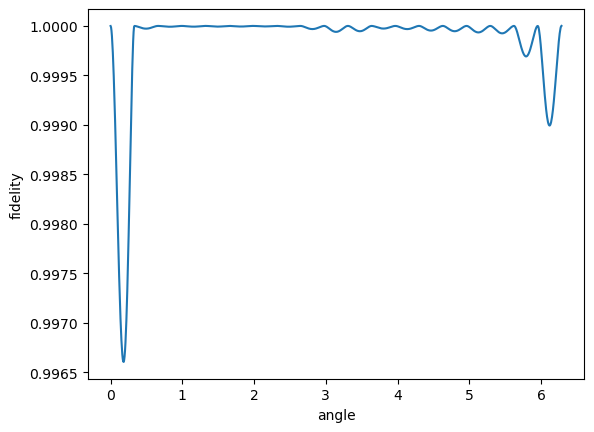

In [9]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [10]:
thetac = min(x, key = lambda v : y[list(x).index(v)])
print("Problem Angle: "+str(thetac))

Problem Angle: 0.18239476867688487


In [11]:
old_starter = coefficients[0]
new_coefficients = []
new_fidelities = []
problem_thetas = [thetac]
for _ in range(10):
    new_coefficients = []
    new_fidelities = []
    print("------------")
    print("Iteration: "+str(_))
    print("------------")
    theta_list = list(np.linspace(0,2*np.pi,20))+problem_thetas
    theta_list.sort()
    for theta in theta_list:
        u0 = np.zeros(N*len(H_ops))
        if(theta==0):
            u0 = old_starter
        else:
            u0 = new_coefficients[len(new_coefficients)-1]
        result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                            ,x0=u0
                         )
        new_coefficients.append(result.x)
        new_fidelities.append(-1*result.fun)
        print("------------")
        print("Angle "+str(theta))
        print("Loss "+str(result.fun))
        f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
        print("Fidelity "+str(f))
        print("------------")
    old_starter=new_coefficients[0]
    x=np.linspace(0,2*np.pi,1000)
    y=[]
    new_coefficients=np.array(new_coefficients)
    for i in x:
        y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,theta_list,new_coefficients)))
    thetac = min(x, key = lambda v : y[list(x).index(v)])
    print("Problem Angle: "+str(thetac))
    problem_thetas.append(thetac)



------------
Iteration: 0
------------
------------
Angle 0.0
Loss -0.9999990108933223
Fidelity 0.9999990108933223
------------
------------
Angle 0.18239476867688487
Loss -0.9999999999805401
Fidelity 0.9999999999805401
------------
------------
Angle 0.3306939635357677
Loss -0.9999999996132763
Fidelity 0.9999999996132763
------------
------------
Angle 0.6613879270715354
Loss -0.9999999998118214
Fidelity 0.9999999998118214
------------
------------
Angle 0.992081890607303
Loss -0.9999999999052794
Fidelity 0.9999999999052794
------------
------------
Angle 1.3227758541430708
Loss -0.9999999996536579
Fidelity 0.9999999996536579
------------
------------
Angle 1.6534698176788385
Loss -0.9999999996539034
Fidelity 0.9999999996539034
------------
------------
Angle 1.984163781214606
Loss -0.999999999906785
Fidelity 0.999999999906785
------------
------------
Angle 2.3148577447503738
Loss -0.9999999987263807
Fidelity 0.9999999987263807
------------
------------
Angle 2.6455517082861415
Loss 

------------
Angle 2.9762456718219092
Loss -0.9999999996303318
Fidelity 0.9999999996303318
------------
------------
Angle 3.306939635357677
Loss -0.9999999996535748
Fidelity 0.9999999996535748
------------
------------
Angle 3.6376335988934447
Loss -0.9999999996817652
Fidelity 0.9999999996817652
------------
------------
Angle 3.968327562429212
Loss -0.9999999926333553
Fidelity 0.9999999926333553
------------
------------
Angle 4.29902152596498
Loss -0.9999999965742623
Fidelity 0.9999999965742623
------------
------------
Angle 4.6297154895007475
Loss -0.9999999999887533
Fidelity 0.9999999999887533
------------
------------
Angle 4.960409453036515
Loss -0.9999999995714318
Fidelity 0.9999999995714318
------------
------------
Angle 5.291103416572283
Loss -0.9999999995980713
Fidelity 0.9999999995980713
------------
------------
Angle 5.621797380108051
Loss -0.9999999976371742
Fidelity 0.9999999976371742
------------
------------
Angle 5.9524913436438185
Loss -0.9999999994485858
Fidelity

------------
Angle 3.1447373909807737
Loss -0.9999999989263846
Fidelity 0.9999999989263846
------------
------------
Angle 3.306939635357677
Loss -0.9999999993223441
Fidelity 0.9999999993223441
------------
------------
Angle 3.6376335988934447
Loss -0.9999999997207396
Fidelity 0.9999999997207396
------------
------------
Angle 3.968327562429212
Loss -0.9999999970000539
Fidelity 0.9999999970000539
------------
------------
Angle 4.29902152596498
Loss -0.9999999976472413
Fidelity 0.9999999976472413
------------
------------
Angle 4.6297154895007475
Loss -0.9999999960893163
Fidelity 0.9999999960893163
------------
------------
Angle 4.960409453036515
Loss -0.999999998638126
Fidelity 0.999999998638126
------------
------------
Angle 5.291103416572283
Loss -0.9999999999573689
Fidelity 0.9999999999573689
------------
------------
Angle 5.621797380108051
Loss -0.9999999944603135
Fidelity 0.9999999944603135
------------
------------
Angle 5.9524913436438185
Loss -0.999999983784503
Fidelity 0.

------------
Angle 0.992081890607303
Loss -0.9999999970299019
Fidelity 0.9999999970299019
------------
------------
Angle 1.3227758541430708
Loss -0.9999999991674428
Fidelity 0.9999999991674428
------------
------------
Angle 1.6534698176788385
Loss -0.9999999987855176
Fidelity 0.9999999987855176
------------
------------
Angle 1.984163781214606
Loss -0.9999999965110213
Fidelity 0.9999999965110213
------------
------------
Angle 2.3148577447503738
Loss -0.999999998937554
Fidelity 0.999999998937554
------------
------------
Angle 2.6455517082861415
Loss -0.9999999965371735
Fidelity 0.9999999965371735
------------
------------
Angle 2.8113952275368117
Loss -0.9999999997297784
Fidelity 0.9999999997297784
------------
------------
Angle 2.9762456718219092
Loss -0.9999999998850655
Fidelity 0.9999999998850655
------------
------------
Angle 3.1447373909807737
Loss -0.9999999992364199
Fidelity 0.9999999992364199
------------
------------
Angle 3.306939635357677
Loss -0.9999999997846394
Fideli

In [12]:
new_coefficients=np.array(new_coefficients)
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,theta_list,new_coefficients)))

Text(0, 0.5, 'fidelity')

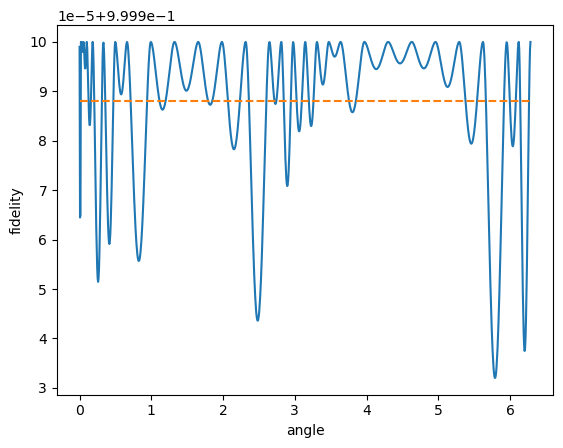

In [13]:
plt.plot(x,y)
plt.plot(x,[np.mean(y)]*len(x),'--')
plt.xlabel("angle")
plt.ylabel("fidelity")

In [14]:
print("Mean Fidelity: "+str(np.mean(y)))
print("Max Fidelity: "+str(np.max(y)))
print("Min Fidelity: "+str(np.min(y)))
print("Largest Amplitude: "+str(np.max(np.abs(new_coefficients))))

Mean Fidelity: 0.9999880321921535
Max Fidelity: 0.9999999999919367
Min Fidelity: 0.9999319937000133
Largest Amplitude: 7.534787446573458
